Objective: Starting from Joyce's optimized distal-input TMS simulation, modify so that the input hits only a portion of the cells in the column as opposed to all of them, modeling how TMS would only activate a portion of the supragranular axons providing distal input. Also, add a current injection to the somas of a portion of each cell type to model how TMS activates a portion of their axons directly, which then causes current to reach the soma through the AP propagating backwards from the axon.

Tuning will come last, but the distal input modification should simply involve including the probability parameter, assuming it works as expected.

The soma current injection which models direct activation by TMS is the main distinguishing addition. This could be accomplished with another drive that hits the somas, but requires changing the allowed synapses to the somas of pyramidal cells and introduces the nuances of synaptic dynamics. The ideal approach would be to add a current injection rather than a synapse, which could be achieve with HNN's tonic bias, except that the bias cannot target cells based on probability.


In [1]:
import hnn_core
from hnn_core import calcium_model, read_params, simulate_dipole, average_dipoles, read_dipole, MPIBackend
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import pickle
import numpy as np
import json
import os

%matplotlib inline

In [2]:
limited = False

In [3]:
run_name = 'direct_opt_full'
os.makedirs(f'optimization_files/{run_name}', exist_ok=True)

In [4]:
with open('optimization_files/BETA9_distal/net.pkl', 'rb') as f:
    BETA9_opt_net = pickle.load(f)
BETA9_opt_net: hnn_core.Network

In [5]:
exp_dpl = read_dipole('optimization_files/BETA09_s1loc_10mm.txt')

In [6]:
tms_net = deepcopy(BETA9_opt_net)
# Delete first distal drive evdist2
del tms_net.external_drives['evdist2']

tms_net_init = deepcopy(tms_net)

# Add distal w/ probability
tms_net_init.add_evoked_drive(
    name='tms_distal',
    mu=6.528485,
    sigma=1.0040786,
    numspikes=1,
    location='distal',
    # n_drive_cells=None,
    # cell_specific=None,
    weights_ampa={'L2_basket': 0.0024741719999999997, 'L2_pyramidal': 0.0031460039999999996, 'L5_pyramidal': 0.030831731999999997},
    weights_nmda={'L2_basket': 0.039215124, 'L2_pyramidal': 0.004143708, 'L5_pyramidal': 0.006008543999999999},
    space_constant=1e6,
    synaptic_delays={'L2_basket': 0.1, 'L2_pyramidal': 0.1, 'L5_pyramidal': 0.1},
    probability=0.8,
)
# Add direct w/ cell-type specific probability
t0 = 6.5 # Tune
tms_net_init.add_tonic_bias(
    bias_name='tms_direct',
    t0=t0,
    tstop=t0+0.3,
    amplitude=      {'L2_basket':    2, 
                     'L2_pyramidal': 10, 
                     'L5_basket':    2,
                     'L5_pyramidal': 30},
    probability=    {'L2_basket':    0.5,
                     'L2_pyramidal': 0.5,
                     'L5_basket':    0.5,
                     'L5_pyramidal': 0.5}, # Tune
)

In [7]:
with open('optimization_files/BETA9_distal/net.json', 'r') as f:
    BETA9_opt_net_params = json.load(f)

In [8]:
def set_params(net: hnn_core.Network, params: dict):
    if limited:
        # Add external drives from BETA9_opt_net_params for limited optimization
        for drive_name in ['evprox1', 'evprox2', 'evprox3', 'evdist1', 'evdist3']: # Exclude evdist2
            drive_dict = BETA9_opt_net_params['external_drives'][drive_name]
            net.add_evoked_drive(
                name=drive_name,
                mu=drive_dict['dynamics']['mu'],
                sigma=drive_dict['dynamics']['sigma'],
                numspikes=drive_dict['dynamics']['numspikes'],
                location=drive_dict['location'],
                weights_ampa=drive_dict['weights_ampa'],
                weights_nmda=drive_dict['weights_nmda'],
                space_constant=1e6,
                synaptic_delays=drive_dict['synaptic_delays'],
                probability=drive_dict["probability"],
                event_seed=drive_dict["event_seed"],
                conn_seed=drive_dict["conn_seed"],
            )
    else:
        # Add external drives from optimizer params
        for drive_name in ['evprox1', 'evprox2', 'evprox3', 'evdist1', 'evdist3', 'tms_distal']: # Exclude evdist2
            if 'dist' in drive_name:
                location = 'distal'
                weights_ampa = {'L2_basket':    params[f'{drive_name}_ampa_L2_basket'], 
                                'L2_pyramidal': params[f'{drive_name}_ampa_L2_pyramidal'], 
                                'L5_pyramidal': params[f'{drive_name}_ampa_L5_pyramidal']}
                weights_nmda = {'L2_basket':    params[f'{drive_name}_nmda_L2_basket'], 
                                'L2_pyramidal': params[f'{drive_name}_nmda_L2_pyramidal'], 
                                'L5_pyramidal': params[f'{drive_name}_nmda_L5_pyramidal']}
                synaptic_delays = {'L2_basket': 0.1, 'L2_pyramidal': 0.1, 'L5_pyramidal': 0.1}
            else:
                location = 'proximal'
                weights_ampa = {'L2_basket':    params[f'{drive_name}_ampa_L2_basket'], 
                                'L2_pyramidal': params[f'{drive_name}_ampa_L2_pyramidal'], 
                                'L5_basket':    params[f'{drive_name}_ampa_L5_basket'], 
                                'L5_pyramidal': params[f'{drive_name}_ampa_L5_pyramidal']}
                weights_nmda = {'L2_basket':    params[f'{drive_name}_nmda_L2_basket'], 
                                'L2_pyramidal': params[f'{drive_name}_nmda_L2_pyramidal'], 
                                'L5_basket':    params[f'{drive_name}_nmda_L5_basket'], 
                                'L5_pyramidal': params[f'{drive_name}_nmda_L5_pyramidal']}
                synaptic_delays = {'L2_basket': 0.1, 'L2_pyramidal': 0.1, 'L5_basket': 1.0, 'L5_pyramidal': 1.0}
            
            # Set the probability for TMS drives
            if 'tms' in drive_name:
                probability = params[f'{drive_name}_probability']
            else:
                probability = 1.0

            net.add_evoked_drive(
                name=drive_name,
                mu=params[f'{drive_name}_mu'],
                sigma=params[f'{drive_name}_sigma'],
                numspikes=1,
                location=location,
                weights_ampa=weights_ampa,
                weights_nmda=weights_nmda,
                space_constant=1e6,
                synaptic_delays=synaptic_delays,
                probability=probability,
            )

    # Add direct stim w/ cell-type specific probability
    t0 = params['tms_direct_t0']
    net.add_tonic_bias(
        bias_name='tms_direct',
        t0=t0,
        tstop=t0+0.3,
        amplitude=      {'L2_basket':   2, 
                        'L2_pyramidal': 10, 
                        'L5_basket':    2,
                        'L5_pyramidal': 30},
        probability=    {'L2_basket':   params['tms_direct_L2_basket_probability'],
                        'L2_pyramidal': params['tms_direct_L2_pyramidal_probability'],
                        'L5_basket':    params['tms_direct_L5_basket_probability'],
                        'L5_pyramidal': params['tms_direct_L5_pyramidal_probability']},
    )

In [9]:
constraints = dict({# tms_direct
                    'tms_direct_t0': (0., 10.),
                    'tms_direct_L2_basket_probability': (0., 1.),
                    'tms_direct_L2_pyramidal_probability': (0., 1.),
                    'tms_direct_L5_basket_probability': (0., 1.),
                    'tms_direct_L5_pyramidal_probability': (0., 1.),
                    # tms_distal
                    'tms_distal_mu': (0., 10.),
                    'tms_distal_sigma': (0., 5.),
                    'tms_distal_ampa_L2_basket': (0.01, 1.),
                    'tms_distal_ampa_L2_pyramidal': (0.01, 1.),
                    'tms_distal_ampa_L5_pyramidal': (0.01, 1.),
                    'tms_distal_nmda_L2_basket': (0.01, 1.),
                    'tms_distal_nmda_L2_pyramidal': (0.01, 1.),
                    'tms_distal_nmda_L5_pyramidal': (0.01, 1.),
                    'tms_distal_probability': (0., 1.),
                    # evprox1
                    'evprox1_mu': (20., 40.),
                    'evprox1_sigma': (1., 6.),
                    'evprox1_ampa_L2_basket': (0.01, 1.),
                    'evprox1_ampa_L2_pyramidal': (0.01, 1.),
                    'evprox1_ampa_L5_basket': (0.01, 1.),
                    'evprox1_ampa_L5_pyramidal': (0.01, 1.),
                    'evprox1_nmda_L2_basket': (0.01, 1.),
                    'evprox1_nmda_L2_pyramidal': (0.01, 1.),
                    'evprox1_nmda_L5_basket': (0.01, 1.),
                    'evprox1_nmda_L5_pyramidal': (0.01, 1.),
                    # evdist1
                    'evdist1_mu': (30., 80.),
                    'evdist1_sigma': (6., 14.),
                    'evdist1_ampa_L2_basket': (0.01, 1.),
                    'evdist1_ampa_L2_pyramidal': (0.01, 1.),
                    'evdist1_ampa_L5_pyramidal': (0.01, 1.),
                    'evdist1_nmda_L2_basket': (0.01, 1.),
                    'evdist1_nmda_L2_pyramidal': (0.01, 1.),
                    'evdist1_nmda_L5_pyramidal': (0.01, 1.),
                    # evprox3
                    'evprox3_mu': (90., 150.),
                    'evprox3_sigma': (8., 16.),
                    'evprox3_ampa_L2_basket': (0.01, 1.),
                    'evprox3_ampa_L2_pyramidal': (0.01, 1.),
                    'evprox3_ampa_L5_basket': (0.01, 1.),
                    'evprox3_ampa_L5_pyramidal': (0.01, 1.),
                    'evprox3_nmda_L2_basket': (0.01, 1.),
                    'evprox3_nmda_L2_pyramidal': (0.01, 1.),
                    'evprox3_nmda_L5_basket': (0.01, 1.),
                    'evprox3_nmda_L5_pyramidal': (0.01, 1.),
                    # evdist3
                    'evdist3_mu': (130., 210.),
                    'evdist3_sigma': (10., 20.),
                    'evdist3_ampa_L2_basket': (0.01, 1.),
                    'evdist3_ampa_L2_pyramidal': (0.01, 1.),
                    'evdist3_ampa_L5_pyramidal': (0.01, 1.),
                    'evdist3_nmda_L2_basket': (0.01, 1.),
                    'evdist3_nmda_L2_pyramidal': (0.01, 1.),
                    'evdist3_nmda_L5_pyramidal': (0.01, 1.),
                    # evprox2
                    'evprox2_mu': (180., 280.),
                    'evprox2_sigma': (10., 20.),
                    'evprox2_ampa_L2_basket': (0.01, 1.),
                    'evprox2_ampa_L2_pyramidal': (0.01, 1.),
                    'evprox2_ampa_L5_basket': (0.01, 1.),
                    'evprox2_ampa_L5_pyramidal': (0.01, 1.),
                    'evprox2_nmda_L2_basket': (0.01, 1.),
                    'evprox2_nmda_L2_pyramidal': (0.01, 1.),
                    'evprox2_nmda_L5_basket': (0.01, 1.),
                    'evprox2_nmda_L5_pyramidal': (0.01, 1.),})

In [10]:
from hnn_core.optimization import Optimizer

scale_factor = 0.1
smooth_window_len = 20

exp_dpl_cpy = deepcopy(exp_dpl)
exp_dpl_cpy.times *= 1e3

optim = Optimizer(calcium_model(), tstop=300, constraints=constraints,
                  set_params=set_params)
# with MPIBackend(n_procs=8, mpi_cmd='mpiexec'):
optim.fit(target=exp_dpl_cpy, scale_factor=scale_factor,
              smooth_window_len=smooth_window_len)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from C:\Users\jacob\Documents\Thesis\hnn_tms_direct\hnn_core\mod\nrnmech.dll
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms

In [16]:
with open(f'optimization_files/{run_name}/net.pkl', 'wb') as f:
    pickle.dump(optim.net_, f)
# with open(f'optimization_files/{run_name}/net.json', 'w') as f:
#     json.dump(optim.net_.to_dict(), f, indent=4)
# optim.net_.write_configuration(f'optimization_files/{run_name}/net.json')
with open(f'optimization_files/{run_name}/optimizer.pkl', 'wb') as f:
    pickle.dump(optim, f)

In [17]:
direct_init_dpl = simulate_dipole(tms_net_init, tstop=300)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...


In [20]:
average_dipoles(direct_init_dpl).write('optimization_files/init_direct/dpl.txt')
with open('optimization_files/init_direct/net.pkl', 'wb') as f:
    pickle.dump(tms_net_init, f)

In [21]:
direct_opt_dpls = simulate_dipole(optim.net_, tstop=300, n_trials=5)
with open(f'optimization_files/{run_name}/dpls.pkl', 'wb') as f:
    pickle.dump(direct_opt_dpls, f)
average_dipoles(direct_opt_dpls).write(f'optimization_files/{run_name}/av_dpl.txt')

Joblib will run 5 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Building the NEURON model
[Done]
Trial 2: 0.03 ms...
Trial 2: 10.0 ms...
Trial 2: 20.0 ms...
Trial 2: 30.0 ms...
Trial 2: 40.0 ms...
Trial 2: 50.0 ms...
Trial 2: 60.0 ms...
Trial 2: 70.0 ms...
Trial 2: 80.0 ms...
Trial 2: 90.0 ms...
Trial 2: 100.0 ms...
Trial 2: 110.0 ms.

C:\Users\jacob\Documents\Thesis\hnn_tms_direct\hnn_core\dipole.py:752: UserWarning: Saving Dipole to file that is an average of 5 trials
  warnings.warn(


In [22]:
with open('optimization_files/BETA9_distal/dpls.pkl', 'rb') as f:
    distal_opt_dpls = pickle.load(f)


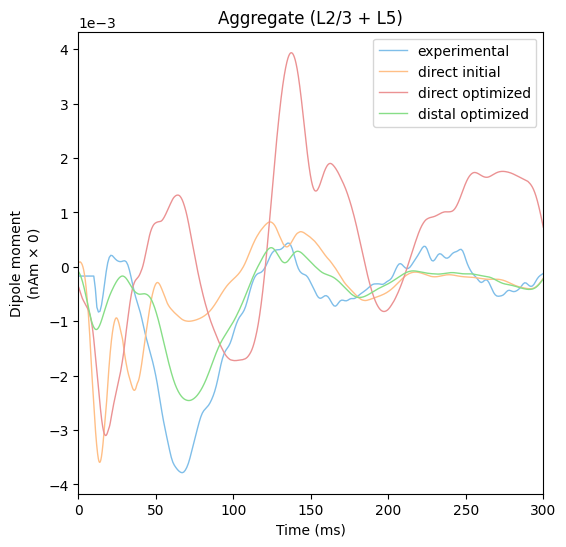

In [23]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(6, 6))

scale_factor = 0.1
smooth_window_len = 20

direct_init_dpl_plot = deepcopy(direct_init_dpl)[0]
direct_init_dpl_plot.scale(scale_factor)
direct_init_dpl_plot.smooth(smooth_window_len)

direct_opt_dpl_plot = average_dipoles(direct_opt_dpls)
direct_opt_dpl_plot.scale(scale_factor)
direct_opt_dpl_plot.smooth(smooth_window_len)

distal_opt_dpl_plot = average_dipoles(distal_opt_dpls)
distal_opt_dpl_plot.scale(scale_factor)
distal_opt_dpl_plot.smooth(smooth_window_len)

exp_dpl_cpy.plot(ax=axes, layer='agg', show=False, color='tab:blue')
direct_init_dpl_plot.plot(ax=axes, layer='agg', show=False, color='tab:orange')
direct_opt_dpl_plot.plot(ax=axes, layer='agg', show=False, color='tab:red')
distal_opt_dpl_plot.plot(ax=axes, layer='agg', show=False, color='tab:green')
axes.legend(['experimental', 'direct initial', 'direct optimized', 'distal optimized'])
# optim.net_.cell_response.plot_spikes_hist(ax=axes[1], show=False)
plt.show()

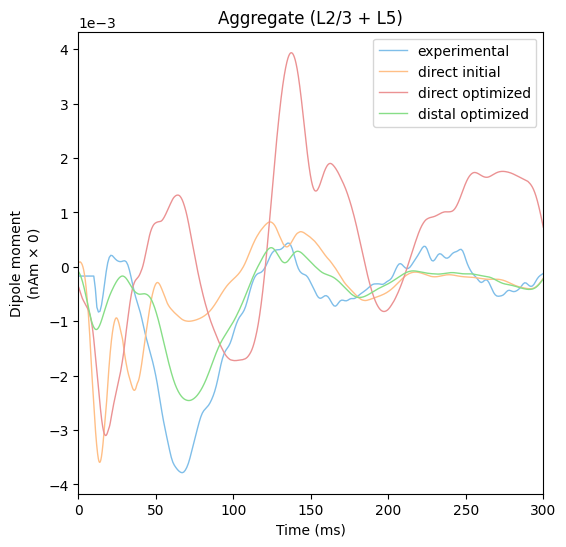

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(6, 6))

scale_factor = 0.1
smooth_window_len = 20

direct_init_dpl_plot = deepcopy(direct_init_dpl)[0]
direct_init_dpl_plot.scale(scale_factor)
direct_init_dpl_plot.smooth(smooth_window_len)

direct_opt_dpl_plot = average_dipoles(direct_opt_dpls)
direct_opt_dpl_plot.scale(scale_factor)
direct_opt_dpl_plot.smooth(smooth_window_len)

distal_opt_dpl_plot = average_dipoles(distal_opt_dpls)
distal_opt_dpl_plot.scale(scale_factor)
distal_opt_dpl_plot.smooth(smooth_window_len)

exp_dpl_cpy.plot(ax=axes, layer='agg', show=False, color='tab:blue')
direct_init_dpl_plot.plot(ax=axes, layer='agg', show=False, color='tab:orange')
direct_opt_dpl_plot.plot(ax=axes, layer='agg', show=False, color='tab:red')
distal_opt_dpl_plot.plot(ax=axes, layer='agg', show=False, color='tab:green')
axes.legend(['experimental', 'direct initial', 'direct optimized', 'distal optimized'])
# optim.net_.cell_response.plot_spikes_hist(ax=axes[1], show=False)
plt.show()

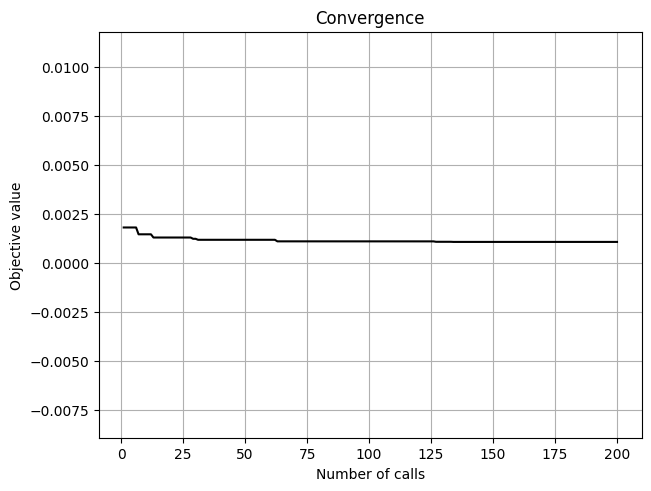

In [ ]:
fig1 = optim.plot_convergence(show=False)
plt.show()